In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from tqdm.notebook import tqdm

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level, various_metrics
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints')

models_to_compare = {}
for file in os.listdir(checkpoint_dir):
    if file.startswith('binary_cl2'):
        if file.endswith('binary_cl2'):
            nickname = 'current'
        else:
            nickname = re.search('(binary_cl2)_(.*)', file).group(2)
        nickname = 'model_' + nickname
        try:
            res = pd.read_csv(os.path.join(checkpoint_dir, file, 'val_results500.csv'))
            res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
            models_to_compare[nickname] = {'original_name': file, 'df': res}
        except:
            pass

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [6]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

In [7]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))

In [8]:
assert test500.couples.isin(gene_pairs_test).all()

# PLOTS

In [9]:
N_iters = 25

In [10]:
def balance_df(df):
    negs = df[df.ground_truth == 0]
    poss = df[df.ground_truth == 1]
    
    n_to_sample = min(poss.shape[0], negs.shape[0])

    if poss.shape[0] > negs.shape[0]:
        return pd.concat([poss.sample(n_to_sample), negs], axis = 0).reset_index(drop = True)
    else:
        return pd.concat([negs.sample(n_to_sample), poss], axis = 0).reset_index(drop = True)

In [11]:
results = {}
set_collected = []

In [12]:
key_name = 'full_data'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
key_name = 'easypos_easyneg_hardneg'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
key_name = 'easypos_easyneg_hardneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
key_name = 'easypos_smartneg'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
key_name = 'easypos_smartneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

In [17]:
key_name = 'easypos_smartneg_not_in_train_55_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.55)|(res.probability<(1-0.55))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

key_name = 'easypos_smartneg_not_in_train_6_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.6)|(res.probability<(1-0.6))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result    

key_name = 'easypos_smartneg_not_in_train_65_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.65)|(res.probability<(1-0.65))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

key_name = 'easypos_smartneg_not_in_train_7_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.7)|(res.probability<(1-0.7))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result
    
key_name = 'easypos_smartneg_not_in_train_75_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.75)|(res.probability<(1-0.75))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result
    
key_name = 'easypos_smartneg_not_in_train_80_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.80)|(res.probability<(1-0.80))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
metric_to_print = 'acc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 acc: 0.575
model_2 acc: 0.57
model_4 acc: 0.553
model_5 acc: 0.553
model_old acc: 0.576
model_6 acc: 0.555
model_3 acc: 0.562
model_7 acc: 0.574
model_8 acc: 0.568
model_10e13 acc: 0.575
model_10e18 acc: 0.575
model_10e34 acc: 0.573
model_11 acc: 0.57
model_12e15 acc: 0.574
model_12e34 acc: 0.575


---  easypos_easyneg_hardneg  --- 
model_1 acc: 0.674
model_2 acc: 0.662
model_4 acc: 0.633
model_5 acc: 0.641
model_old acc: 0.646
model_6 acc: 0.638
model_3 acc: 0.642
model_7 acc: 0.665
model_8 acc: 0.655
model_10e13 acc: 0.669
model_10e18 acc: 0.667
model_10e34 acc: 0.693
model_11 acc: 0.641
model_12e15 acc: 0.664
model_12e34 acc: 0.682


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 acc: 0.625
model_2 acc: 0.665
model_4 acc: 0.605
model_5 acc: 0.56
model_old acc: 0.627
model_6 acc: 0.6
model_3 acc: 0.615
model_7 acc: 0.56
model_8 acc: 0.682
model_10e13 acc: 0.627
model_10e18 acc: 0.667
model_10e34 acc: 0.657
model_11 acc: 0.585
model_12e15 acc: 0.6

In [19]:
metric_to_print = 'roc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 roc: 0.611
model_2 roc: 0.603
model_4 roc: 0.581
model_5 roc: 0.577
model_old roc: 0.613
model_6 roc: 0.584
model_3 roc: 0.593
model_7 roc: 0.61
model_8 roc: 0.604
model_10e13 roc: 0.612
model_10e18 roc: 0.612
model_10e34 roc: 0.608
model_11 roc: 0.607
model_12e15 roc: 0.606
model_12e34 roc: 0.608


---  easypos_easyneg_hardneg  --- 
model_1 roc: 0.745
model_2 roc: 0.754
model_4 roc: 0.72
model_5 roc: 0.727
model_old roc: 0.706
model_6 roc: 0.723
model_3 roc: 0.702
model_7 roc: 0.734
model_8 roc: 0.71
model_10e13 roc: 0.726
model_10e18 roc: 0.735
model_10e34 roc: 0.768
model_11 roc: 0.706
model_12e15 roc: 0.728
model_12e34 roc: 0.758


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 roc: 0.718
model_2 roc: 0.75
model_4 roc: 0.796
model_5 roc: 0.809
model_old roc: 0.706
model_6 roc: 0.799
model_3 roc: 0.687
model_7 roc: 0.633
model_8 roc: 0.698
model_10e13 roc: 0.732
model_10e18 roc: 0.676
model_10e34 roc: 0.692
model_11 roc: 0.676
model_12e15 roc: 0

In [20]:
metric_to_print = 'perc_data'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 perc_data: 100.0
model_2 perc_data: 100.0
model_4 perc_data: 100.0
model_5 perc_data: 100.0
model_old perc_data: 100.0
model_6 perc_data: 100.0
model_3 perc_data: 100.0
model_7 perc_data: 100.0
model_8 perc_data: 100.0
model_10e13 perc_data: 100.0
model_10e18 perc_data: 100.0
model_10e34 perc_data: 100.0
model_11 perc_data: 100.0
model_12e15 perc_data: 100.0
model_12e34 perc_data: 100.0


---  easypos_easyneg_hardneg  --- 
model_1 perc_data: 36.65
model_2 perc_data: 36.65
model_4 perc_data: 36.65
model_5 perc_data: 36.65
model_old perc_data: 36.65
model_6 perc_data: 36.65
model_3 perc_data: 36.65
model_7 perc_data: 36.65
model_8 perc_data: 36.65
model_10e13 perc_data: 36.65
model_10e18 perc_data: 36.65
model_10e34 perc_data: 36.65
model_11 perc_data: 36.65
model_12e15 perc_data: 36.65
model_12e34 perc_data: 36.65


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 perc_data: 0.35
model_2 perc_data: 0.35
model_4 perc_data: 0.35
model_5 perc_data: 0.35


### Plots

In [21]:
#modify the results dict

# Iterate through the outer dictionary
for key1 in results.keys():
    inner_dict = results[key1]

    # Create a new 'intarna' dictionary with np.nan values
    intarna_dict = {key: np.nan for key in inner_dict['model_1'].keys()}
    
    intarna_roc_value = inner_dict['model_1']['roc_intarna']

    # Remove 'roc_intarna' from all inner dictionaries
    for key2 in inner_dict.keys():
        if 'roc_intarna' in inner_dict[key2]:
            del inner_dict[key2]['roc_intarna']

    # Add 'intarna' dictionary with 'roc' field set to 'roc_intarna'
    inner_dict['intarna'] = {**intarna_dict}
    inner_dict['intarna']['roc'] = intarna_roc_value

In [24]:
def plot_bars(values, metric_labels=metric_to_print, models_label=best_models, title=''):
    # Set width of bar
    barWidth = 0.1
    fig, ax = plt.subplots(figsize=(12, 8))
    
    brs = []
    brs.append(np.arange(len(metric_to_print)))
    for i in range(len(best_models)):
        brs.append([x + barWidth for x in brs[i]])
    
    colors = 'crgybkm'
    
    for i in range(len(best_models)):
        plt.bar(brs[i], values[i], color=colors[i], width=barWidth,
                edgecolor='grey', label=best_models[i])
        
        # Add value labels on top of each bar
        for j, value in enumerate(values[i]):
            ax.text(brs[i][j], value + 0.01, str(np.round(value, 2)), ha='center', va='bottom')
        
    plt.xlabel('Metric', fontweight='bold', fontsize=12)
    plt.ylabel('Metric value', fontweight='bold', fontsize=12)
    plt.xticks([r + barWidth for r in range(len(metric_to_print))], metric_to_print)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    plt.show()

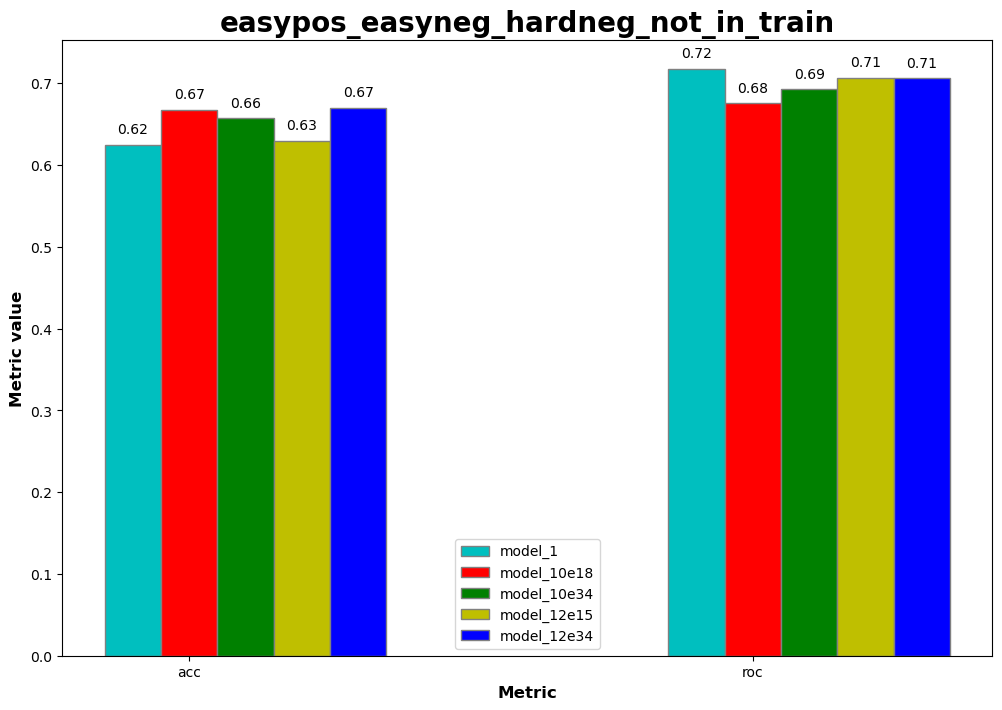

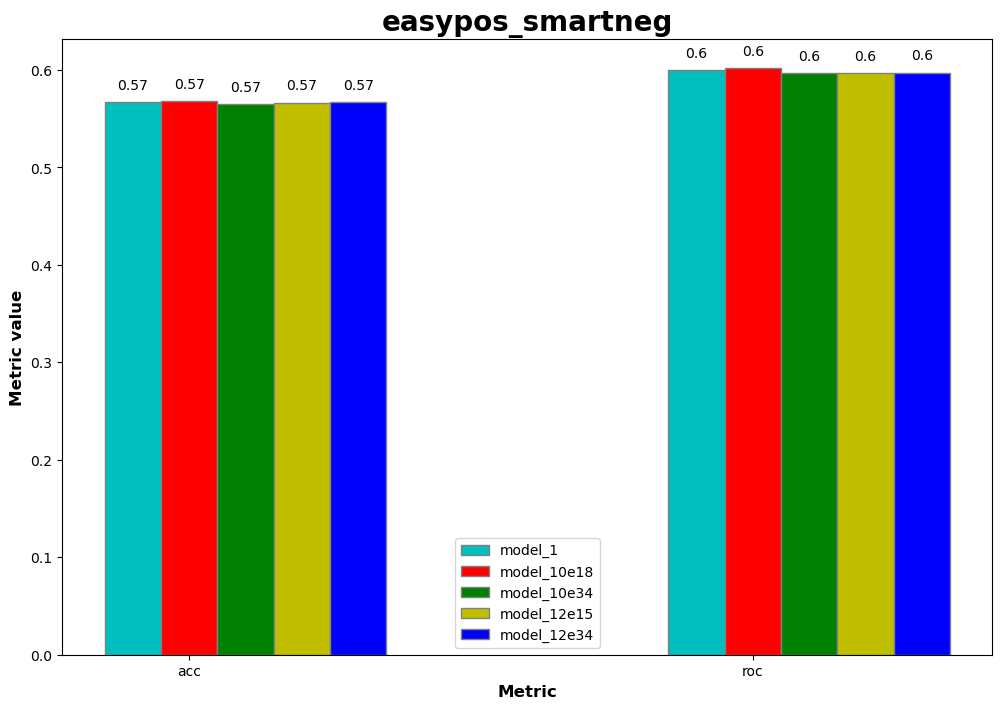

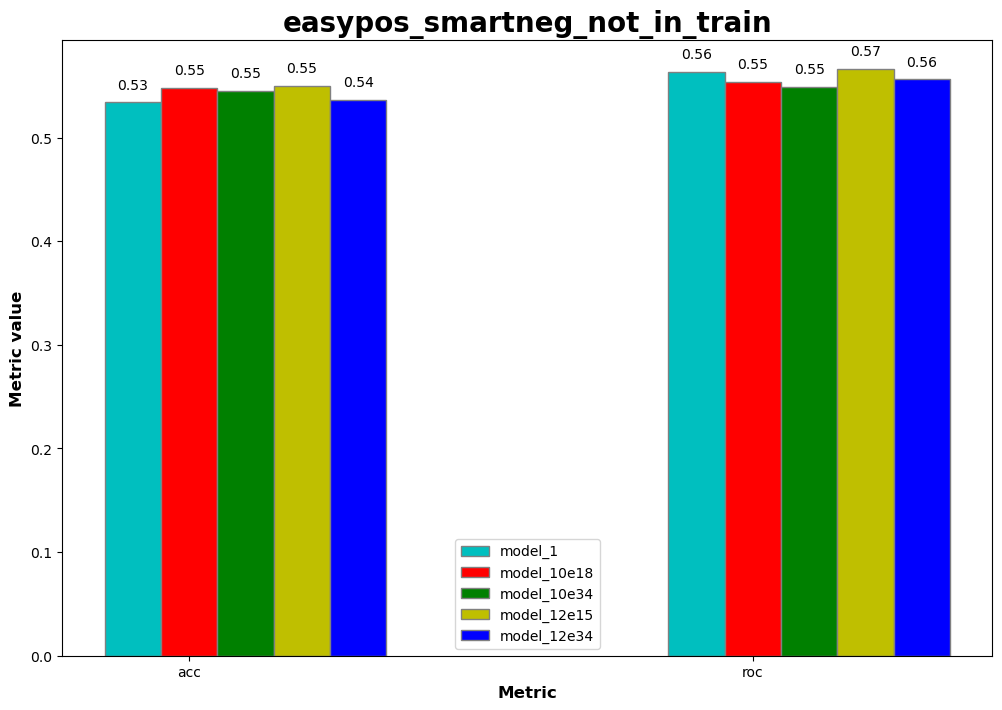

In [25]:
best_models = ['model_1', 'model_10e18','model_10e34', 'model_12e15', 'model_12e34']# 'model_11', 'model_12e15'] 'intarna', 
set_to_print = ['easypos_easyneg_hardneg_not_in_train', 'easypos_smartneg', 'easypos_smartneg_not_in_train']#, 'easypos_smartneg_not_in_train_55_conf', 'easypos_smartneg_not_in_train_65_conf']

for current_set in set_to_print:
    if current_set in ['easypos_smartneg_not_in_train_65_conf', 'easypos_smartneg_not_in_train_55_conf']:
        metric_to_print = ['acc', 'roc', 'perc_data']
    else:
        metric_to_print = ['acc', 'roc']
    
    values = []
    for model in best_models:
        if model == 'intarna':
            original_name = 'intarna'
        else:
            original_name = models_to_compare[model]['original_name']
        model_list = []
        for metric in metric_to_print:
            model_list.append(results[current_set][model][metric])
        values.append(model_list)
    
    plot_bars(values, metric_labels = metric_to_print, models_label = best_models, title = current_set)

In [26]:
conf_levels = ['easypos_smartneg_not_in_train', 'easypos_smartneg_not_in_train_55_conf', 'easypos_smartneg_not_in_train_6_conf', 'easypos_smartneg_not_in_train_65_conf', 'easypos_smartneg_not_in_train_7_conf', 'easypos_smartneg_not_in_train_75_conf', 'easypos_smartneg_not_in_train_80_conf']
metric = 'acc'

plot_conf = {}

for model in best_models:
    plot_conf[model] = {}
    plot_conf[model][metric] = []
    plot_conf[model]['perc_data'] = []
    for conf_level in conf_levels:
        plot_conf[model][metric].append(results[conf_level][model][metric])
        plot_conf[model]['perc_data'].append(results[conf_level][model]['perc_data'])

Text(0.5, 1.0, 'acc X confidence level')

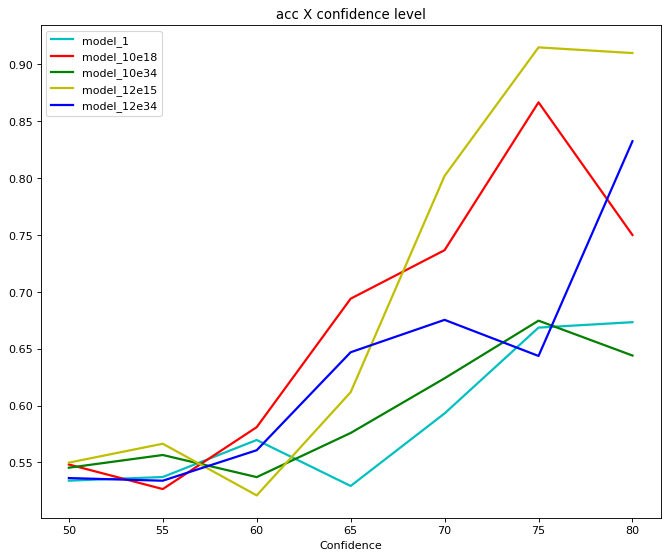

In [27]:
plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array([50, 55, 60, 65, 70, 75, 80])
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model][metric], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Confidence")
plt.title(f'{metric} X confidence level')

Text(0.5, 1.0, 'Perc X confidence level')

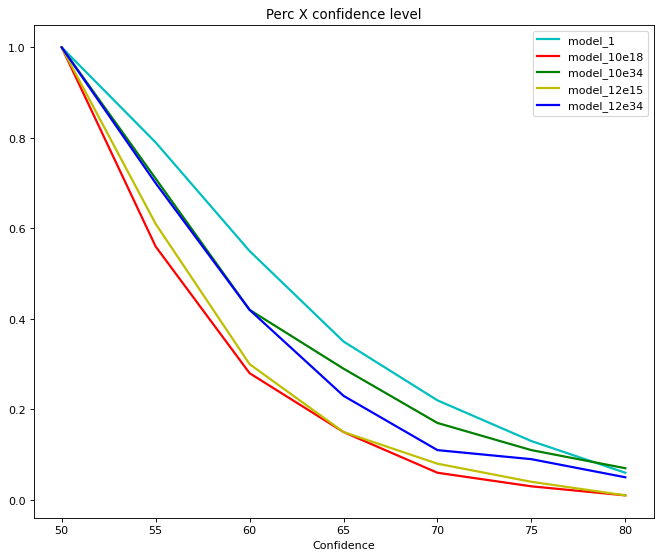

In [40]:
plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array([50, 55, 60, 65, 70, 75, 80])
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model]['perc_data'], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Confidence")
plt.title('Perc X confidence level')

### Explore best configuration

In [33]:
best_model_chosen = 'model_1'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7fd608a95e40>, <dataset.data.SmartNegAugment object at 0x7fd608a97e80>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7fd608a96b90>, <dataset.data.SmartNegAugment object at 0x7fd6089c5ab0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [34]:
best_model_chosen = 'model_10e34'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 0, 'dividing_factor': 10, 'output_channels_mlp': 512, 'n_channels1_cnn': 400, 'n_channels2_cnn': 800, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7fd613127970>, <dataset.data.SmartNegAugment object at 0x7fd6089c4df0>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7fd608a97ca0>, <dataset.data.SmartNegAugment object at 0x7fd613154bb0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star